# Upgraded LGBM
Use LGBMRegressor, simple model to fit with x/y only without eval_set.  

## Import and look through the datasets

In [1]:
import gresearch_crypto
import pandas as pd
import numpy as np
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

In [2]:
df_train = pd.read_csv('../input/g-research-crypto-forecasting/train.csv')
df_test = pd.read_csv('../input/g-research-crypto-forecasting/example_test.csv')

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24236806 entries, 0 to 24236805
Data columns (total 10 columns):
 #   Column     Dtype  
---  ------     -----  
 0   timestamp  int64  
 1   Asset_ID   int64  
 2   Count      float64
 3   Open       float64
 4   High       float64
 5   Low        float64
 6   Close      float64
 7   Volume     float64
 8   VWAP       float64
 9   Target     float64
dtypes: float64(8), int64(2)
memory usage: 1.8 GB


Training data is huge. It may be because of unnecessary Float64 of Dtypes. (e.g. "Count" doesn't need to be Float64.)

In [4]:
df_train.describe()

timestamp      Asset_ID         Count          Open          High  \
count  2.423681e+07  2.423681e+07  2.423681e+07  2.423681e+07  2.423681e+07   
mean   1.577120e+09  6.292544e+00  2.864593e+02  1.432640e+03  1.436350e+03   
std    3.323350e+07  4.091861e+00  8.673982e+02  6.029605e+03  6.039482e+03   
min    1.514765e+09  0.000000e+00  1.000000e+00  1.170400e-03  1.195000e-03   
25%    1.549011e+09  3.000000e+00  1.900000e+01  2.676500e-01  2.681600e-01   
50%    1.578372e+09  6.000000e+00  6.400000e+01  1.428860e+01  1.431250e+01   
75%    1.606198e+09  9.000000e+00  2.210000e+02  2.288743e+02  2.293000e+02   
max    1.632182e+09  1.300000e+01  1.650160e+05  6.480594e+04  6.490000e+04   

                Low         Close        Volume          VWAP        Target  
count  2.423681e+07  2.423681e+07  2.423681e+07  2.423680e+07  2.348647e+07  
mean   1.429568e+03  1.432640e+03  2.868530e+05           NaN  7.121752e-06  
std    6.020261e+03  6.029611e+03  2.433935e+06           NaN  5.679042e-03  
min    2.000000e-04  1.171400e-03 -3.662812e-01          -inf -5.093509e-01  
25%    2.669000e-01  2.676483e-01  1.410725e+02  2.676368e-01 -1.694354e-03  
50%    1.426300e+01  1.428920e+01  1.295415e+03  1.428769e+01 -4.289844e-05  
75%    2.284200e+02  2.288729e+02  2.729764e+04  2.288728e+02  1.601520e-03  
max    6.467053e+04  6.480854e+04  7.597554e+08           inf  9.641699e-01

## Replace Nan, Inf, -Inf by Mean  

In [5]:
df_train.isnull().sum()

timestamp         0
Asset_ID          0
Count             0
Open              0
High              0
Low               0
Close             0
Volume            0
VWAP              9
Target       750338
dtype: int64

In [6]:
a1 = df_train["VWAP"].isin([np.inf])
a2 = df_train["VWAP"].isin([-np.inf])
a3 = df_train["VWAP"].isin([np.nan])
print ("inf:", a1.sum(), "  -inf:", a2.sum(), "  nan:", a3.sum())

inf: 6   -inf: 1   nan: 9


In [7]:
df_train[df_train["Target"].isna()].head()

timestamp  Asset_ID  Count      Open     High      Low    Close  \
7    1514764860        11    7.0  329.0900  329.880  329.090  329.460   
44   1514765160         7   76.0   26.4255   27.073   25.550   26.400   
95   1514765520        11    8.0  327.6700  327.680  326.770  326.770   
111  1514765640        11    8.0  326.9300  327.960  326.220  327.910   
116  1514765700         7   12.0   26.4410   27.070   25.812   26.399   

          Volume        VWAP  Target  
7       6.635710  329.454118     NaN  
44   1857.936529   26.352542     NaN  
95     17.901633  326.990493     NaN  
111    26.840300  326.476237     NaN  
116   163.830076   26.449597     NaN

In [8]:
df_train["VWAP"]=df_train["VWAP"].replace([np.inf, -np.inf], np.nan)

vwap_mean = df_train[["Asset_ID", "VWAP"]].groupby("Asset_ID").mean().reset_index()
vwap_mean.columns = ["Asset_ID", "vwap_mean"]

df_train = pd.merge(df_train, vwap_mean, on = "Asset_ID", how = "left")
df_train.loc[(df_train["VWAP"].isnull()), "VWAP"] = df_train["vwap_mean"]
df_train = df_train.drop("vwap_mean", axis = 1)
df_train.describe()

timestamp      Asset_ID         Count          Open          High  \
count  2.423681e+07  2.423681e+07  2.423681e+07  2.423681e+07  2.423681e+07   
mean   1.577120e+09  6.292544e+00  2.864593e+02  1.432640e+03  1.436350e+03   
std    3.323350e+07  4.091861e+00  8.673982e+02  6.029605e+03  6.039482e+03   
min    1.514765e+09  0.000000e+00  1.000000e+00  1.170400e-03  1.195000e-03   
25%    1.549011e+09  3.000000e+00  1.900000e+01  2.676500e-01  2.681600e-01   
50%    1.578372e+09  6.000000e+00  6.400000e+01  1.428860e+01  1.431250e+01   
75%    1.606198e+09  9.000000e+00  2.210000e+02  2.288743e+02  2.293000e+02   
max    1.632182e+09  1.300000e+01  1.650160e+05  6.480594e+04  6.490000e+04   

                Low         Close        Volume          VWAP        Target  
count  2.423681e+07  2.423681e+07  2.423681e+07  2.423681e+07  2.348647e+07  
mean   1.429568e+03  1.432640e+03  2.868530e+05  1.432630e+03  7.121752e-06  
std    6.020261e+03  6.029611e+03  2.433935e+06  6.029558e+03  5.679042e-03  
min    2.000000e-04  1.171400e-03 -3.662812e-01 -7.997471e+02 -5.093509e-01  
25%    2.669000e-01  2.676483e-01  1.410725e+02  2.676372e-01 -1.694354e-03  
50%    1.426300e+01  1.428920e+01  1.295415e+03  1.428771e+01 -4.289844e-05  
75%    2.284200e+02  2.288729e+02  2.729764e+04  2.288731e+02  1.601520e-03  
max    6.467053e+04  6.480854e+04  7.597554e+08  6.479982e+04  9.641699e-01

## Add "Weight" as one of the features  

In [9]:
df_asset = pd.read_csv('../input/g-research-crypto-forecasting/asset_details.csv')
df_asset

Asset_ID    Weight        Asset_Name
0          2  2.397895      Bitcoin Cash
1          0  4.304065      Binance Coin
2          1  6.779922           Bitcoin
3          5  1.386294            EOS.IO
4          7  2.079442  Ethereum Classic
5          6  5.894403          Ethereum
6          9  2.397895          Litecoin
7         11  1.609438            Monero
8         13  1.791759              TRON
9         12  2.079442           Stellar
10         3  4.406719           Cardano
11         8  1.098612              IOTA
12        10  1.098612             Maker
13         4  3.555348          Dogecoin

In [10]:
def feature_adjust(df) :
    feature_cols = ['Asset_ID', 'Close', 'Count', 'High', 'Low', 'Open', 'VWAP','Volume', 'timestamp'] 
                #"Upper_shadow", "Lower_shadow"] #Bull_Bear
    categories = ["Asset_ID", "timestamp"] #Bull_Bear
    
    x = df[feature_cols].copy()
    #df = pd.merge(df, df_asset, on = "Asset_ID", how = "left")
    #df = df.drop("Asset_Name", axis = 1)
    return x

In [11]:
df_train = df_train[~df_train.isin([np.nan, np.inf, -np.inf]).any(1)].reset_index(drop=True)
#df_train = feature_adjust(df_train)

In [12]:
df_train

timestamp  Asset_ID  Count          Open          High  \
0         1514764860         2   40.0   2376.580000   2399.500000   
1         1514764860         0    5.0      8.530000      8.530000   
2         1514764860         1  229.0  13835.194000  14013.800000   
3         1514764860         5   32.0      7.659600      7.659600   
4         1514764860         7    5.0     25.920000     25.920000   
...              ...       ...    ...           ...           ...   
23486463  1632181440         9  163.0    156.502000    156.620000   
23486464  1632181440        10   23.0   2420.146667   2421.000000   
23486465  1632181440        13  512.0      0.090989      0.091133   
23486466  1632181440        12  193.0      0.280952      0.281300   
23486467  1632181440        11   38.0    232.075000    232.300000   

                   Low         Close        Volume          VWAP    Target  
0          2357.140000   2374.590000  1.923301e+01   2373.116392 -0.004218  
1             8.530000      8.530000  7.838000e+01      8.530000 -0.014399  
2         13666.110000  13850.176000  3.155006e+01  13827.062093 -0.014643  
3             7.656700      7.657600  6.626713e+03      7.657713 -0.013922  
4            25.874000     25.877000  1.210873e+02     25.891363 -0.008264  
...                ...           ...           ...           ...       ...  
23486463    156.000000    156.075667  7.381963e+02    156.260253 -0.001154  
23486464   2412.779000   2414.069667  1.315794e+00   2417.326038  0.009831  
23486465      0.090831      0.090885  1.900695e+06      0.090943  0.004163  
23486466      0.280175      0.280403  1.628699e+05      0.280655  0.000449  
23486467    231.310000    231.680000  4.914804e+01    231.794078  0.002568  

[23486468 rows x 10 columns]

In [13]:
def reduce_mem_usage(df):
    """
    To reduce the memory usage of dataset.
    Parameters
    ----------
    df: dataframe.

    Returns
    -------
    df: pd.DataFrame
        reduced memory dataframe where redundant data types are replaced with proper types.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
#         else:
#             df[col] = df[col].astype('category')

    df["Count"] = df["Count"].astype(np.int16)

    end_mem = df.memory_usage().sum() / 1024**2
    
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
     
    return df

df_train = reduce_mem_usage(df_train)

Memory usage of dataframe is 1791.88 MB
Memory usage after optimization is: 515.16 MB
Decreased by 71.2%


In [14]:
df_test = reduce_mem_usage(df_test)

Memory usage of dataframe is 0.00 MB
Memory usage after optimization is: 0.00 MB
Decreased by 72.0%


# Apply "eval_set"

## LGBM (test_size = 0, N_estimators = 200)  
The epoch of training went over 100 without early stopping and arrived at almost 200. Increase the n_estimators from the default 100 to 200. 

In [15]:
lgb_params = {
    "objective": "regression",
    "n_estimators" : 5000,     # <-- (9) change from 200 to 500
    "num_leaves" : 300,       # <-- (10) Added parameter
    "learning_rate" : 0.09,   # <-- (10) Added parameter
    "random_seed" : 1234}

# Modeling for each Asset ID
  
However, the price trend is of course varied for each Asset, thus tried to fit per each Asset.  

In [16]:
def get_model (asset_id) :
    
    df = df_train[df_train["Asset_ID"] == asset_id]
    
    x = feature_adjust(df)
    #x = df[feature_cols].copy()
    y = df['Target'].copy()
        
    model = lgb.LGBMRegressor(**lgb_params)
    model.fit(x, y)
    
    return model

In [17]:
asset_ids = list(df_asset["Asset_ID"].unique())
asset_ids.sort()
models = {}

for asset_id in asset_ids :
        
    print(f"Training model for  ID={asset_id}")
    
    model = get_model(asset_id)
    models[asset_id] = model

Training model for  ID=0
Training model for  ID=1
Training model for  ID=2
Training model for  ID=3
Training model for  ID=4
Training model for  ID=5
Training model for  ID=6
Training model for  ID=7
Training model for  ID=8
Training model for  ID=9
Training model for  ID=10
Training model for  ID=11
Training model for  ID=12
Training model for  ID=13


In [18]:
env = gresearch_crypto.make_env()
iter_test = env.iter_test()

In [19]:
for i, (df_test, df_pred) in enumerate(iter_test) :
    df_test = reduce_mem_usage(df_test)
    
    for j , row in df_test.iterrows():        
        
        model = models[row['Asset_ID']]
        x_test = feature_adjust(row)
        #x_test = x_test.drop(["row_id"])
        y_pred = model.predict(pd.DataFrame([x_test]))[0]
        df_pred.loc[df_pred['row_id'] == row['row_id'], 'Target'] = y_pred
    
    env.predict(df_pred)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
Memory usage of dataframe is 0.00 MB
Memory usage after optimization is: 0.00 MB
Decreased by 58.0%
Memory usage of dataframe is 0.00 MB
Memory usage after optimization is: 0.00 MB
Decreased by 58.0%
Memory usage of dataframe is 0.00 MB
Memory usage after optimization is: 0.00 MB
Decreased by 58.0%
Memory usage of dataframe is 0.00 MB
Memory usage after optimization is: 0.00 MB
Decreased by 58.0%


# Add "Upper_shadow", "Lower shadow" as features
But the result got so bad. Ignore it.

In [20]:
# df["Upper_shadow"] = df["High"] - np.maximum(df["Open"], df['Close'])
# df["Lower_shadow"] = np.minimum(df["Open"], df['Close']) - df["Low"]

# Increase n_estimators from 200 to 500

Increase n_estimators from 200 to 500.

## Adjust Hyperparameters
Try to adjust other hyperparameters (num_leaves, learning_rate)

# Gradual increasing n_estimator from 500 to 5000

Gradually increase n_estimator to see how the score is improved. The score will get worse due to over-fitting if increased the number too much, however, the more and more n_estimator is increased the higher and higher the score becomes.

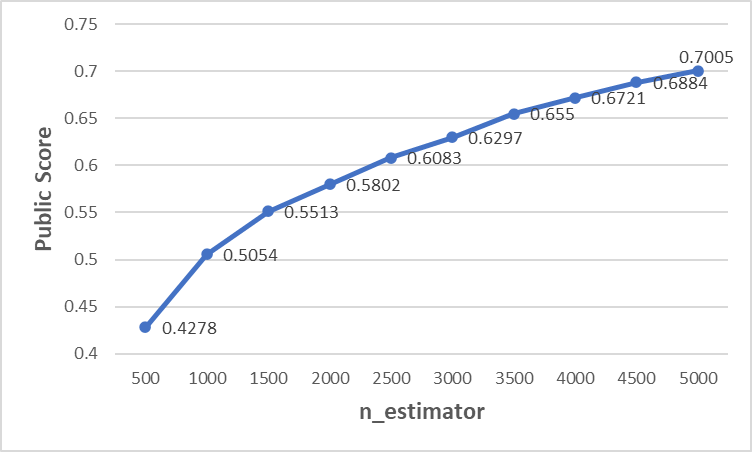